In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_filtered_with_ids = pd.read_pickle("/content/drive/MyDrive/Other/filtered_data1.pkl")

In [ ]:
data_filtered_with_ids["target"] = data_filtered_with_ids["conversions"].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
cols_to_use = list(data_filtered_with_ids.columns)

cols_to_use.remove("date_time")
cols_to_use.remove("conversions")
cols_to_use.remove("impressions")

In [ ]:
train_df = data_filtered_with_ids.loc[data_filtered_with_ids["date_time"] < "2016-09-14", cols_to_use]
valid_df = data_filtered_with_ids.loc[data_filtered_with_ids["date_time"] > "2016-09-14", cols_to_use]

In [ ]:
categorical_cols = ["banner_id", "advertiser_id", "offer_id", "zone_id", "affiliate_id", "geo", "region_code", "city_code",
                    "os_type", "os", "os_version", "device_type", "device", "browser", "lang", "isp", "mobile_isp",
                    "proxy", "netspeed", "day_of_week", "hour"]
nums_cols = ["varp", "varcc", "varpp"]

In [ ]:
transformed_train_list = []
transformed_valid_list = []
for colname in categorical_cols:
    ohe_enc = OneHotEncoder(dtype=np.int8, handle_unknown='ignore', min_frequency=5, sparse_output=True)
    ohe_enc.fit(train_df[[colname]])
    cat_ohe_train = ohe_enc.transform(train_df[[colname]])
    cat_ohe_valid = ohe_enc.transform(valid_df[[colname]])
    for n in range(1, 11):
        pca = TruncatedSVD(n_components=n).fit(cat_ohe_train)
        explained = pca.explained_variance_ratio_
        if sum(explained) > 0.9:
            break
    print(f"Feature '{colname}', components: {n}")
    X_train_pca = pca.transform(cat_ohe_train)
    X_valid_pca = pca.transform(cat_ohe_valid)
    pca_train_df = pd.DataFrame(X_train_pca, columns=[f"PCA_{i+1}_{colname}" for i in range(n)])
    pca_valid_df = pd.DataFrame(X_valid_pca, columns=[f"PCA_{i+1}_{colname}" for i in range(n)])
    transformed_train_list.append(pca_train_df)
    transformed_valid_list.append(pca_valid_df)

Feature 'banner_id', components: 10
Feature 'advertiser_id', components: 10
Feature 'offer_id', components: 10
Feature 'zone_id', components: 10
Feature 'affiliate_id', components: 10
Feature 'geo', components: 10
Feature 'region_code', components: 10
Feature 'city_code', components: 10
Feature 'os_type', components: 2
Feature 'os', components: 4
Feature 'os_version', components: 9
Feature 'device_type', components: 3
Feature 'device', components: 3
Feature 'browser', components: 7
Feature 'lang', components: 9
Feature 'isp', components: 10
Feature 'mobile_isp', components: 10
Feature 'proxy', components: 2
Feature 'netspeed', components: 4
Feature 'day_of_week', components: 6
Feature 'hour', components: 10


In [ ]:
train_df_linear = pd.concat([train_df.drop(categorical_cols, axis=1).reset_index(drop=True)] + transformed_train_list,
                            axis=1)
valid_df_linear = pd.concat([valid_df.drop(categorical_cols, axis=1).reset_index(drop=True)] + transformed_valid_list,
                            axis=1)

In [ ]:
train_df_linear.to_pickle("/content/drive/MyDrive/Other/filtered_data1_train_linear.pkl")
valid_df_linear.to_pickle("/content/drive/MyDrive/Other/filtered_data1_valid_linear.pkl")

In [ ]:
train_df_linear = pd.read_pickle("/content/drive/MyDrive/Other/filtered_data1_train_linear.pkl")
valid_df_linear = pd.read_pickle("/content/drive/MyDrive/Other/filtered_data1_valid_linear.pkl")

In [ ]:
train_df_linear

,varp,varpp,varcc,date_time_ts,CTR,target,PCA_1_banner_id,PCA_2_banner_id,PCA_3_banner_id,PCA_4_banner_id,...,PCA_1_hour,PCA_2_hour,PCA_3_hour,PCA_4_hour,PCA_5_hour,PCA_6_hour,PCA_7_hour,PCA_8_hour,PCA_9_hour,PCA_10_hour
0,4.0,1.0,0.0,2016-09-09 10:00:00,0.0,0,-7.406415e-11,-2.021054e-10,-1.131294e-09,2.130949e-09,...,0.002593,-0.004998,-0.002137,-0.012577,0.009197,-0.004801,0.999747,-0.006712,0.002310,0.005747
1,1.0,2.0,0.0,2016-09-05 14:00:00,0.0,0,3.824203e-06,1.045338e-05,2.299017e-06,8.042087e-05,...,0.929975,-0.329741,0.019126,0.020893,0.128165,-0.016233,-0.004789,-0.006549,0.001602,0.006042
2,4.0,6.0,0.0,2016-09-08 22:00:00,0.0,0,-5.523593e-09,2.007343e-09,9.190839e-09,3.315515e-08,...,0.006841,-0.035676,0.006520,0.013281,0.019745,0.011206,0.000830,-0.011226,-0.003677,0.066549
3,1.0,2.0,0.0,2016-09-10 19:00:00,0.0,0,-9.743689e-06,2.158356e-06,3.668453e-05,-8.463839e-05,...,-0.007476,0.013195,-0.003436,-0.007305,-0.016324,0.011295,-0.000761,-0.000073,-0.000969,0.017755
4,4.0,1.0,0.0,2016-09-10 17:00:00,0.0,0,8.385815e-09,-6.176488e-09,4.283515e-09,-3.316339e-08,...,0.006367,0.040860,-0.011858,-0.030251,-0.007333,-0.052239,-0.006678,0.051328,0.369163,0.906127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816357,4.0,2.0,1.0,2016-09-12 17:00:00,0.0,0,-6.684430e-14,-6.316954e-13,5.735438e-12,-4.364837e-12,...,0.006367,0.040860,-0.011858,-0.030251,-0.007333,-0.052239,-0.006678,0.051328,0.369163,0.906127
816358,1.0,61.0,2.0,2016-09-09 09:00:00,0.0,0,4.325819e-14,-2.151573e-13,-2.613066e-13,1.278268e-12,...,0.009358,0.013371,-0.001260,-0.023902,0.093865,0.992208,0.003121,-0.024898,0.002913,0.047593
816359,4.0,1.0,0.0,2016-09-07 06:00:00,0.0,0,-1.807408e-05,6.913508e-05,3.372710e-04,-2.524498e-04,...,0.020627,-0.037387,0.002013,-0.000805,0.035451,0.005355,-0.003607,-0.004522,0.007641,0.013289
816360,3.0,2.0,0.0,2016-09-08 17:00:00,0.0,0,8.285999e-15,8.851333e-16,-2.335321e-14,4.632809e-14,...,0.006367,0.040860,-0.011858,-0.030251,-0.007333,-0.052239,-0.006678,0.051328,0.369163,0.906127


In [ ]:
valid_df_linear

,varp,varpp,varcc,date_time_ts,CTR,target,PCA_1_banner_id,PCA_2_banner_id,PCA_3_banner_id,PCA_4_banner_id,...,PCA_1_hour,PCA_2_hour,PCA_3_hour,PCA_4_hour,PCA_5_hour,PCA_6_hour,PCA_7_hour,PCA_8_hour,PCA_9_hour,PCA_10_hour
0,1.0,2.0,0.0,2016-09-14 00:00:00,0.0,0,9.255952e-08,-7.631366e-09,-1.921694e-07,5.006941e-07,...,-0.009467,0.003179,0.003122,0.001893,-0.009671,-0.023460,0.000576,0.005234,-0.023168,-0.016437
1,1.0,3.0,0.0,2016-09-14 16:00:00,0.0,0,-1.467545e-10,-8.973163e-11,8.058081e-12,-2.347133e-10,...,-0.000161,-0.019320,0.006466,0.016685,0.011333,0.028408,0.007247,0.997448,0.002717,-0.047625
2,1.0,3.0,3.0,2016-09-15 15:00:00,0.0,0,9.804486e-05,-1.636550e-04,-6.773113e-04,7.500860e-04,...,-0.026139,0.124225,0.798149,0.515042,0.280809,-0.016091,0.005792,-0.012389,0.002268,0.019361
3,1.0,1.0,3.0,2016-09-14 16:00:00,0.0,0,-1.928451e-08,2.604434e-09,6.872973e-07,-1.228694e-06,...,-0.000161,-0.019320,0.006466,0.016685,0.011333,0.028408,0.007247,0.997448,0.002717,-0.047625
4,3.0,4.0,0.0,2016-09-15 16:00:00,0.0,0,-7.816943e-19,9.171113e-19,-2.687811e-18,-8.804061e-18,...,-0.000161,-0.019320,0.006466,0.016685,0.011333,0.028408,0.007247,0.997448,0.002717,-0.047625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127256,1.0,4.0,0.0,2016-09-15 05:00:00,0.0,0,2.920024e-11,-5.563714e-11,8.144512e-11,-4.786875e-11,...,-0.001850,-0.013406,0.000292,-0.004612,0.000205,0.010884,-0.002279,-0.004223,-0.010491,0.036265
127257,1.0,1.0,0.0,2016-09-14 20:00:00,0.0,0,-3.607472e-08,-4.100388e-08,-1.059613e-08,-9.085875e-08,...,0.002213,0.023039,-0.004434,-0.007960,-0.004669,-0.016914,-0.000438,0.011858,0.011909,-0.100569
127258,1.0,3.0,0.0,2016-09-15 06:00:00,0.0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.020627,-0.037387,0.002013,-0.000805,0.035451,0.005355,-0.003607,-0.004522,0.007641,0.013289
127259,4.0,1.0,0.0,2016-09-15 07:00:00,0.0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-0.009434,0.022900,-0.003812,-0.007788,-0.021640,-0.001851,-0.000041,0.006062,-0.005548,-0.046073


In [ ]:
cols_to_drop = ["date_time_ts", "CTR", "target"]

In [ ]:
train_cols = categorical_cols + nums_cols

In [ ]:
lr1 = LogisticRegression(penalty="l2", C=0.1)
lr1.fit(train_df_linear.drop(cols_to_drop, axis=1), train_df_linear["target"])
preds = lr1.predict_proba(valid_df_linear.drop(cols_to_drop, axis=1))
roc_auc_score(valid_df_linear["target"], preds[:,-1])

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.807751581934415

In [ ]:
lr2 = LogisticRegression(penalty="l1", solver="liblinear", C=0.1)
lr2.fit(train_df_linear.drop(cols_to_drop, axis=1), train_df_linear["target"])
preds = lr2.predict_proba(valid_df_linear.drop(cols_to_drop, axis=1))
roc_auc_score(valid_df_linear["target"], preds[:,-1])

0.8063470163149336

In [ ]:
import shap
shap.initjs()

In [ ]:
fe1 = pd.DataFrame([lr1.feature_names_in_, lr1.coef_[0]], index=["feature_name", "coef"]).T

In [ ]:
fe1["abs_coef"] = np.abs(fe1["coef"])
fe1.sort_values("abs_coef", ascending=False).head(50)

,feature_name,coef,abs_coef
118,PCA_8_lang,1.336369,1.336369
20,PCA_8_advertiser_id,1.062864,1.062864
15,PCA_3_advertiser_id,-1.06177,1.06177
26,PCA_4_offer_id,-1.001864,1.001864
107,PCA_4_browser,0.956258,0.956258
7,PCA_5_banner_id,0.951091,0.951091
14,PCA_2_advertiser_id,-0.925981,0.925981
5,PCA_3_banner_id,0.85655,0.85655
56,PCA_4_geo,-0.807217,0.807217
17,PCA_5_advertiser_id,-0.702894,0.702894


In [ ]:
explainer1 = shap.LinearExplainer(lr1, valid_df_linear.drop(cols_to_drop, axis=1), feature_perturbation="correlation_dependent")
shap_values1 = explainer1.shap_values(valid_df_linear.drop(cols_to_drop, axis=1))

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

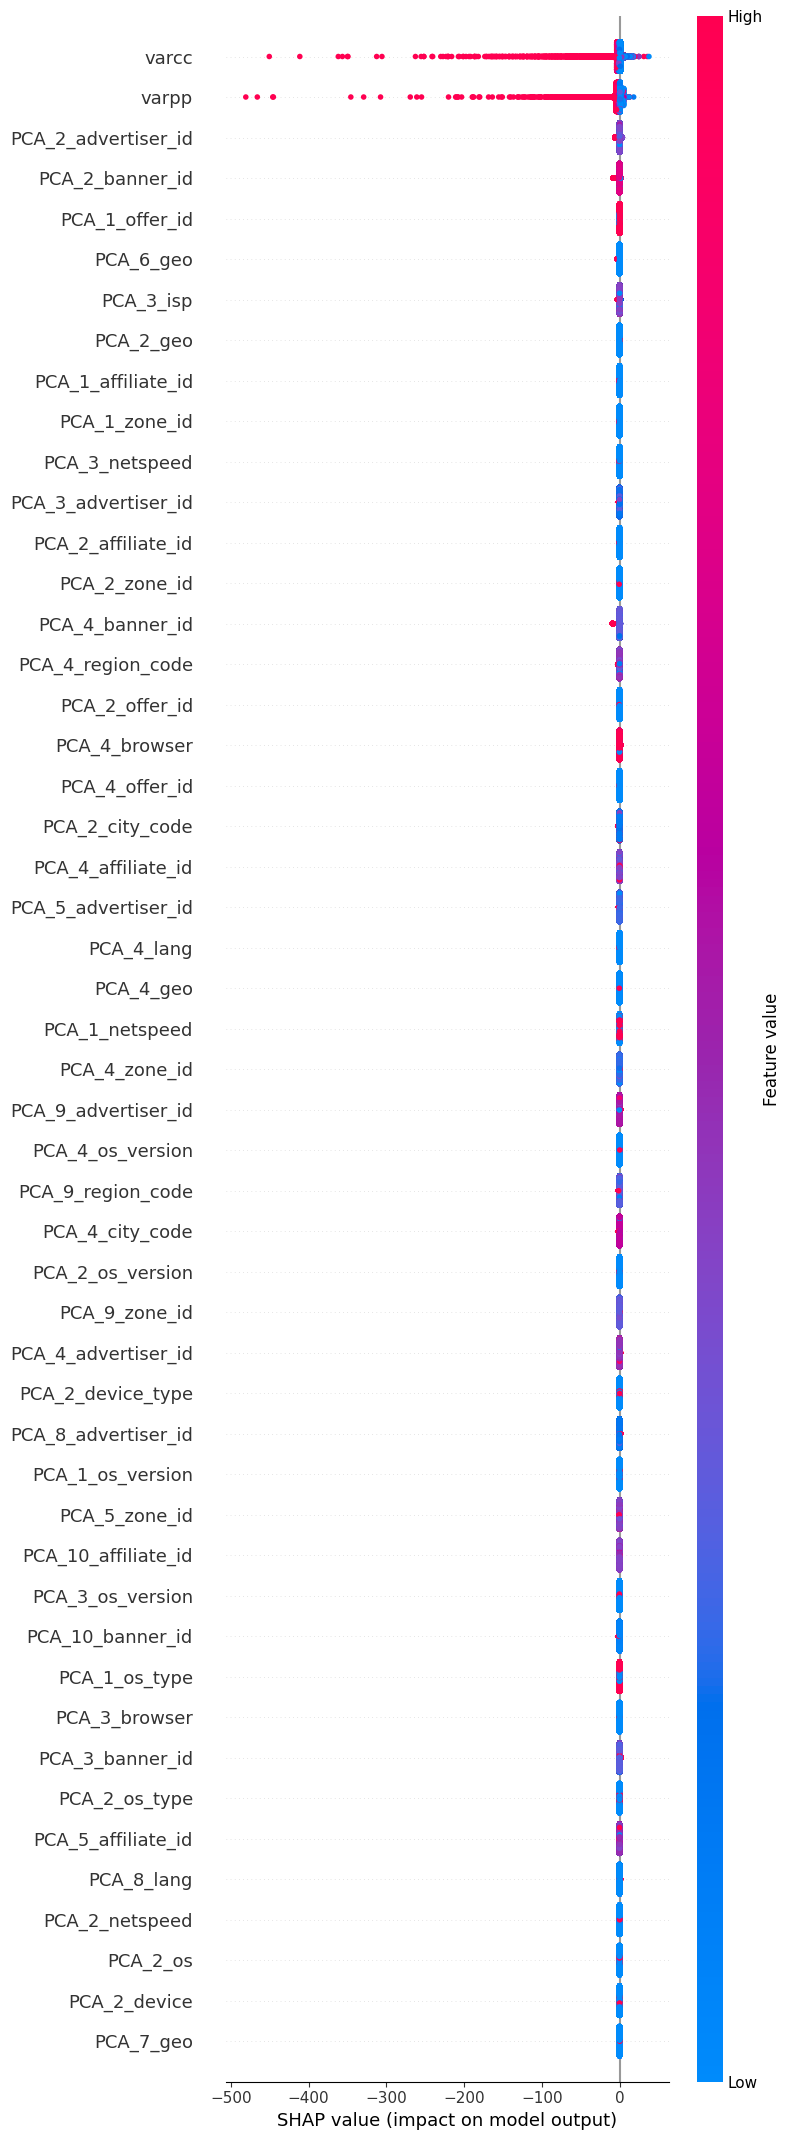

In [ ]:
shap.summary_plot(shap_values1, valid_df_linear.drop(cols_to_drop, axis=1), max_display=50)

In [ ]:
fe1["feature"] = fe1["feature_name"].str.replace("PCA_\d+_", "")
stat2 = fe1.sort_values("abs_coef", ascending=False).iloc[:50,:].groupby("feature")\
  .agg({"feature_name": "count", "abs_coef": ["mean", "max"]})
stat2.columns = ["count", "abs_coef_mean", "abs_coef_max"]
stat2.sort_values("count", ascending=False)

The default value of regex will change from True to False in a future version.


,count,abs_coef_mean,abs_coef_max
feature,,,
advertiser_id,9,0.744143,1.062864
offer_id,7,0.531380,1.001864
banner_id,6,0.612571,0.951091
browser,4,0.622435,0.956258
lang,4,0.598806,1.336369
zone_id,4,0.511280,0.680582
affiliate_id,3,0.548455,0.680582
geo,3,0.492417,0.807217
city_code,2,0.357743,0.412214
